# Community detection on the Flickr social dataset

### Done using the Girvan Newman Algorithm

In [18]:
import numpy as np
import networkx as nx
import pandas as pd
import operator
import matplotlib.pyplot as plt
from time import time

In [2]:
sampled_edges = pd.read_csv('edges_sampled_1.csv', header = None)

all_edges = []
for i in range(len(sampled_edges[0])):
    all_edges.append((sampled_edges[0][i], sampled_edges[1][i]))

# all_edges

G = nx.Graph()

G.add_edges_from(all_edges)

# for i in nx.connected_components(G):
#     print(i)

n = G.number_of_nodes()
A = nx.adj_matrix(G)

In [3]:
def _single_source_shortest_path_basic(G, s):
    S = []
    P = {}
    for v in G:
        P[v] = []
    sigma = dict.fromkeys(G, 0.0)    # sigma[v]=0 for v in G
    D = {}
    sigma[s] = 1.0
    D[s] = 0
    Q = [s]
    while Q:   # use BFS to find shortest paths
        v = Q.pop(0)
        S.append(v)
        Dv = D[v]
        sigmav = sigma[v]
        for w in G[v]:
            if w not in D:
                Q.append(w)
                D[w] = Dv + 1
            if D[w] == Dv + 1:   # this is a shortest path, count paths
                sigma[w] += sigmav
                P[w].append(v)  # predecessors
    return S, P, sigma

def _accumulate_edges(betweenness, S, P, sigma, s):
    delta = dict.fromkeys(S, 0)
    while S:
        w = S.pop()
        coeff = (1.0 + delta[w]) / sigma[w]
        for v in P[w]:
            c = sigma[v] * coeff
            if (v, w) not in betweenness:
                betweenness[(w, v)] += c
            else:
                betweenness[(v, w)] += c
            delta[v] += c
        if w != s:
            betweenness[w] += delta[w]
    return betweenness

In [4]:
def get_betweenness(G):
    betweenness = dict.fromkeys(G, 0.0)  
    betweenness.update(dict.fromkeys(G.edges(), 0.0))

    nodes = G
    for s in nodes:
        S, P, sigma = _single_source_shortest_path_basic(G, s)
        
        betweenness = _accumulate_edges(betweenness, S, P, sigma, s)

    for n in G:  # remove nodes to only return edges
        del betweenness[n]
    return betweenness

In [5]:
def edge_to_remove(G):
    dict_betweenness = get_betweenness(G)
    list_of_tuples = dict_betweenness.items()
#     print(list_of_tuples)
#     list_of_tuples.sort(key = lambda x: x[1], reverse = True)
    max_edge = max(dict_betweenness.items(), key=operator.itemgetter(1))[0]
    u = int(max_edge[0])
    v = int(max_edge[1])
#     print(u)
#     print(v)
    return u,v

In [6]:
def get_modularity(adj_mat, og_graph, new_graph):
    m = og_graph.number_of_edges()
    
    all_nodes_og = list(og_graph.nodes())
    all_nodes_new = list(new_graph.nodes())
#     print(all_nodes_og[0])
    def kroneker(graph, u, v):
        return u in nx.node_connected_component(graph, v)
    Q_val = 0.0
    for i in range(adj_mat.shape[0]):
        for j in range(adj_mat.shape[1]):
            Q_val += (adj_mat[i,j] - (og_graph.degree(all_nodes_og[i])*og_graph.degree(all_nodes_og[j]))/(2*m)) * \
            kroneker(new_graph, all_nodes_new[i], all_nodes_new[j])
    
    Q_val = (1.0/(2*m)) * Q_val
    return(Q_val)

In [7]:
def g_newman(G):
    c = nx.connected_component_subgraphs(G)
    l = len(list(c))
#     print('Number of connected componets are',l)
    u, v = edge_to_remove(G)
#     print('Here uv is:',u,v)
    
    G.remove_edge(u,v)
    c = nx.connected_component_subgraphs(G)
    l = len(list(c))
#     print('Number of connected components now:',l)

In [8]:
def run_gn(G, iters):
    copy_G = G.copy()
    adj_mat = nx.adjacency_matrix(copy_G)
    modularitys = []
    i = 0
    while i < iters:
        g_newman(G)
        mod_now = get_modularity(adj_mat, copy_G, G)
        modularitys.append(mod_now)
        if i%10 == 0: print('Modularity is:',mod_now)
        i += 1
    return modularitys

In [9]:
mods_100 = run_gn(G, 100)

Number of connected componets are 5
Number of connected components now: 5
Modularity is: 0.038374192680675275
Number of connected componets are 5
Number of connected components now: 6
Number of connected componets are 6
Number of connected components now: 7
Number of connected componets are 7
Number of connected components now: 8
Number of connected componets are 8
Number of connected components now: 9
Number of connected componets are 9
Number of connected components now: 10
Number of connected componets are 10
Number of connected components now: 11
Number of connected componets are 11
Number of connected components now: 12
Number of connected componets are 12
Number of connected components now: 13
Number of connected componets are 13
Number of connected components now: 14
Number of connected componets are 14
Number of connected components now: 15
Modularity is: 0.4140472427778816
Number of connected componets are 15
Number of connected components now: 16
Number of connected componets

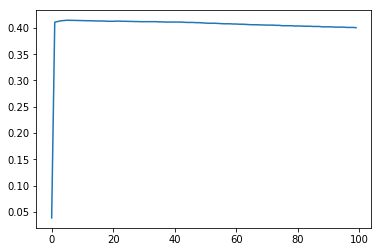

In [16]:
plt.plot(np.arange(0,100), mods_100)

In [ ]:
start_1 = time()
mods_1500 = run_gn(G, 1500)
print('Time taken to finish:',(time() - start_1)/60,'minutes.')

In [ ]:
plt.plot(np.arange(0,1500), mods_1500)